In [1]:
import numpy as np
import pandas as pd

from scipy import polyval, stats
import math
from statsmodels.graphics.mosaicplot import mosaic
import statsmodels.formula.api as sf
import statsmodels.api as sm

import seaborn as sns
sns.set()
import matplotlib.pyplot as plt

from collections import Counter

from math import log
from math import exp
from scipy.stats import boxcox

In [2]:
%matplotlib inline
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (15, 5)
plt.rcParams['font.family'] = 'sans-serif'

In [3]:
df = pd.read_csv('resource/Barcelona airbnb 10.2020.csv')

In [4]:
# df.head()

                                  Shape and data types of the data 
                                     (генеральная совокупность)

In [5]:
df.shape

(19896, 16)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19896 entries, 0 to 19895
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              19896 non-null  int64  
 1   name                            19884 non-null  object 
 2   host_id                         19896 non-null  int64  
 3   host_name                       19889 non-null  object 
 4   neighbourhood_group             19896 non-null  object 
 5   neighbourhood                   19896 non-null  object 
 6   latitude                        19896 non-null  float64
 7   longitude                       19896 non-null  float64
 8   room_type                       19896 non-null  object 
 9   price                           19896 non-null  int64  
 10  minimum_nights                  19896 non-null  int64  
 11  number_of_reviews               19896 non-null  int64  
 12  last_review                     

In [7]:
# Список долей отсутствующих записей для каждого признака
for col in df.columns:
    pct_missing = np.mean(df[col].isnull())
    print('{} - {}%'.format(col, round(pct_missing * 100)))

id - 0%
name - 0%
host_id - 0%
host_name - 0%
neighbourhood_group - 0%
neighbourhood - 0%
latitude - 0%
longitude - 0%
room_type - 0%
price - 0%
minimum_nights - 0%
number_of_reviews - 0%
last_review - 30%
reviews_per_month - 30%
calculated_host_listings_count - 0%
availability_365 - 0%


                                    Data cleaning

### Отсутствующие данные

In [8]:
# Внесение недостающих значений в столбцы name и host_name
df['name'] = df['name'].fillna('MISSING')
df['host_name'] = df['host_name'].fillna('MISSING')

In [9]:
# проверка заполнения недостающих значений 'name'
missing_df = df['name'].str.contains('MISSING')
df[missing_df]['name']

1869    MISSING
2285    MISSING
2685    MISSING
2698    MISSING
2804    MISSING
2890    MISSING
3001    MISSING
3012    MISSING
3358    MISSING
4533    MISSING
4561    MISSING
4661    MISSING
Name: name, dtype: object

Text(0.5, 1.0, 'Тепловая карта пропущенных значений')

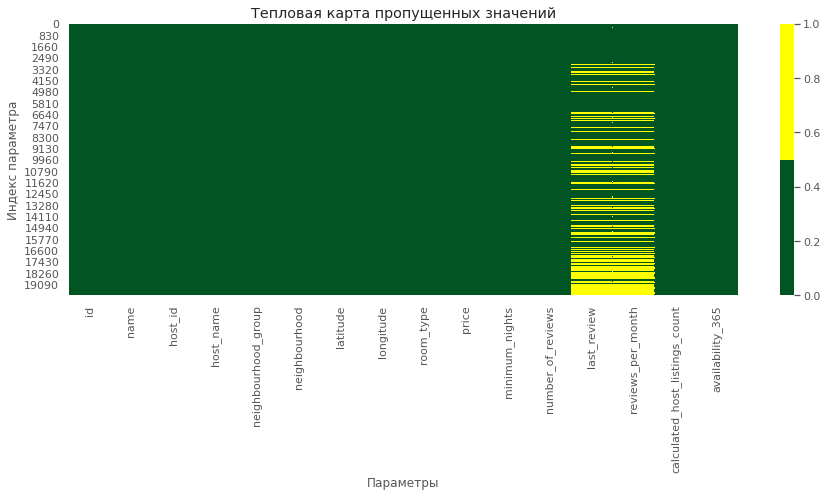

In [10]:
# Отсутствующие значения на тепловой карте
cols = df.columns
colours = ['#005522', '#ffff00']
# желтый - пропущенные данные
sns.heatmap(df[cols].isnull(), cmap=sns.color_palette(colours))
plt.xlabel('Параметры')
plt.ylabel('Индекс параметра')
plt.title('Тепловая карта пропущенных значений')

Диаграмма корреляции для визуализации метрики корреляции между всеми возможными парами числовых переменных в данном наборе данных 

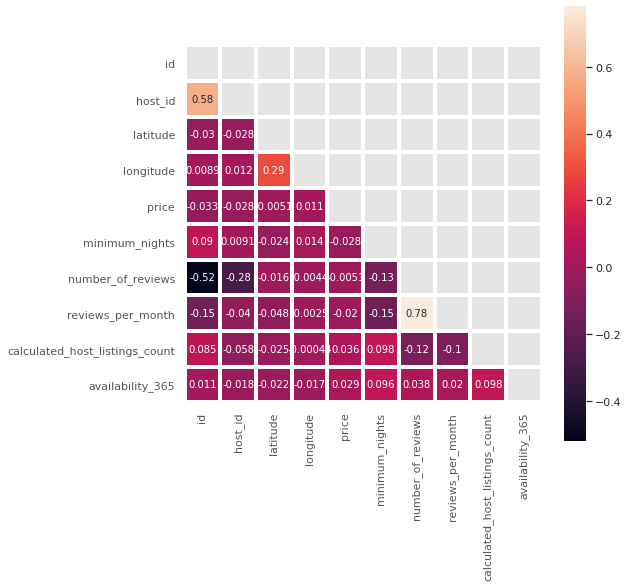

In [11]:
# матрица корреляции между атрибутами объекта
fig, ax = plt.subplots(figsize=(8, 8))
corr = df[[
    'id', 'host_id', 'latitude', 'longitude', 'price', 'minimum_nights',
    'number_of_reviews', 'reviews_per_month', 'calculated_host_listings_count',
    'availability_365'
]].corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style('dark'):
    ax = sns.heatmap(corr,
                     mask=mask,
                     square=True,
                     cbar=True,
                     annot=True,
                     linewidths=3)

In [12]:
#фильтр по пустым ячейкам в столбце reviews_per_month
filtered_nullable = df[df['reviews_per_month'].isnull()]
len(filtered_nullable)

5877

In [13]:
#выбор 2х столбцов по заданному фильтру
filtered_nullable = filtered_nullable[[
    'number_of_reviews', 'reviews_per_month'
]]
# количество отзывов при нулевом значении параметра в месяц
filtered_nullable['number_of_reviews'].value_counts()

0    5877
Name: number_of_reviews, dtype: int64

In [14]:
# замененна значения NAN новым значением 0
df['reviews_per_month'] = df['reviews_per_month'].fillna(0)

In [15]:
# Проверка долей отсутствующих записей для каждого признака после внесения недостающих значений
for col in df.columns:
    pct_missing = np.mean(df[col].isnull())
    print('{} - {}%'.format(col, round(pct_missing * 100)))

id - 0%
name - 0%
host_id - 0%
host_name - 0%
neighbourhood_group - 0%
neighbourhood - 0%
latitude - 0%
longitude - 0%
room_type - 0%
price - 0%
minimum_nights - 0%
number_of_reviews - 0%
last_review - 30%
reviews_per_month - 0%
calculated_host_listings_count - 0%
availability_365 - 0%


### Exploratory Data analysis

#### Анализ параметра id

In [16]:
# проверка на уникальность
[k for k, v in Counter(df['id']).items() if v > 1]
# все значения id уникальны, повторений нет, следовательно весь датасет содержит уникальные данные

[]

#### Анализ параметра price

In [17]:
# Описательная статистика
df['price'].describe()

count    19896.000000
mean        85.995074
std        207.216127
min          0.000000
25%         34.000000
50%         54.000000
75%         93.000000
max      10000.000000
Name: price, dtype: float64

In [18]:
df['price'].median()

54.0

In [19]:
df['price'].mode()[0]

50

In [20]:
# исключение нулевого значения из набора данных
df = df[df['price'] > 0]

Text(0.5, 1.0, 'Стоимость аренды')

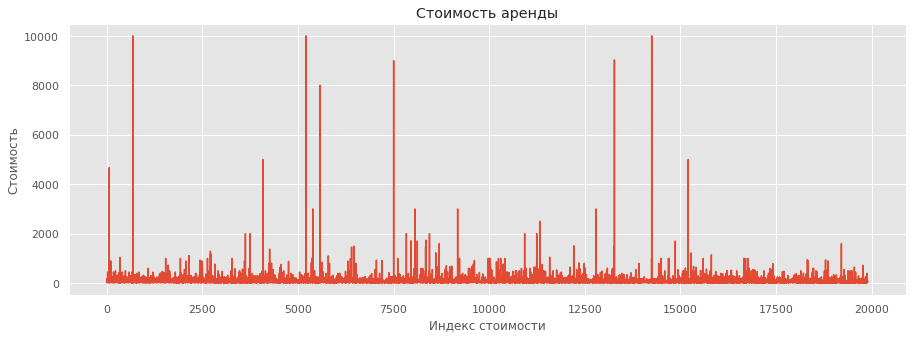

In [21]:
df['price'].plot()
plt.xlabel('Индекс стоимости')
plt.ylabel('Стоимость')
plt.title('Стоимость аренды')

Text(0.5, 1.0, 'Распределение параметра price')

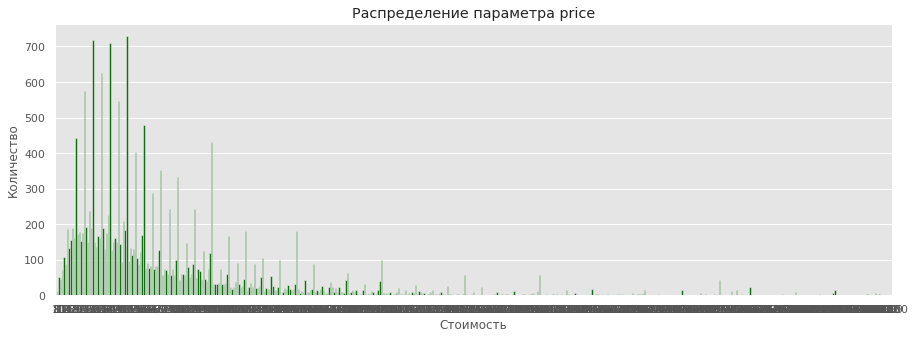

In [22]:
# Распределение параметра price
sns.countplot(x='price', data=df, color='green')
plt.xlabel('Стоимость')
plt.ylabel('Количество')
plt.title('Распределение параметра price')

##### Лог-трансформация параметра price

In [23]:
# лог-трансформация
def invert_boxcox(value, lam):
    if lam == 0:
        return exp(value)

    return exp(log(lam * value + 1) / lam)

data = df["price"]
transformed, lmbda = boxcox(data)

Text(0.5, 1.0, 'Распределение параметра price')

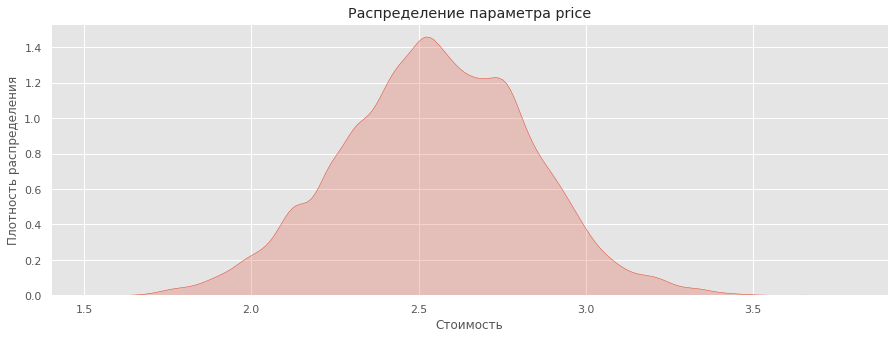

In [24]:
# Распределение параметра price после лог-трансформации
sns.kdeplot(transformed, shade=True, clip=(0, 500))
plt.xlabel('Стоимость')
plt.ylabel('Плотность распределения')
plt.title("Распределение параметра price")

##### Нетипичные значения

/home/kate/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='price'>

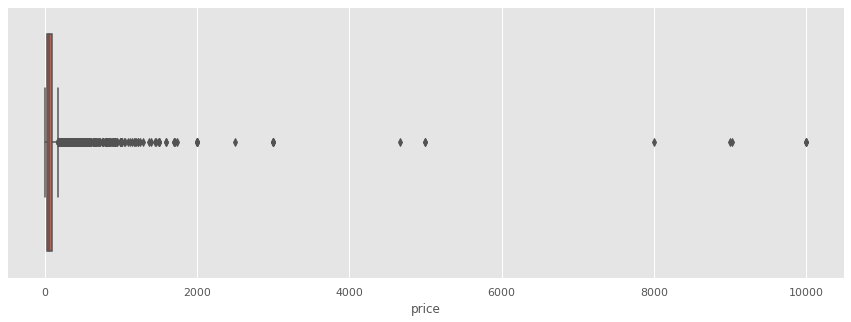

In [25]:
sns.boxplot(df['price'], orient='h')

In [26]:
# Объем нетипичных данных параметра price

df_price = df['price']
upper_quartile = np.percentile(df_price, 75)
lower_quartile = np.percentile(df_price, 25)
iqr = upper_quartile - lower_quartile  #Межквартильный диапазон
upper_whisker = df_price[df_price <= upper_quartile +
                         1.5 * iqr].max()  #1.5 межквартильных диапазона

filtered_emissions = df[
    df['price'] >
    upper_whisker]  #выборка данных с нетипичными значениями стоимости

len(filtered_emissions) / len(
    df
) * 100  #процент нетипичных значений стоимости в генеральной совокупности

7.031917567227946

##### Оценка нетипичных данных по длительности аренды

Text(0.5, 1.0, 'Длительность аренды для нетипичных значений')

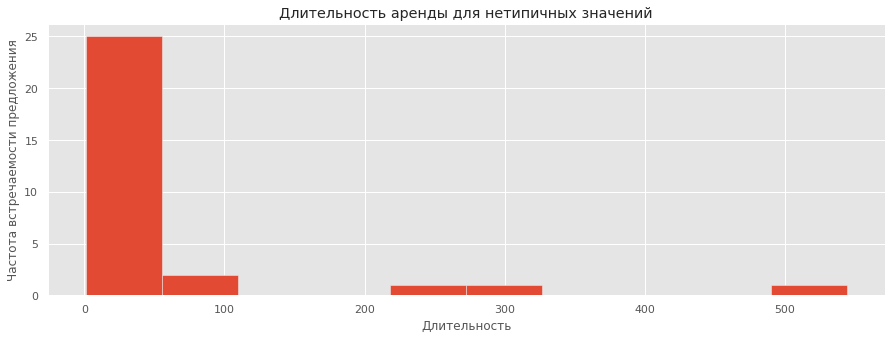

In [27]:
# Нужно изменить график, чтоб 365 дней было на оси х, а 1 раз на оси у (сейчас в графике не учтен ключ)

# Длительность аренды для нетипичных значений
filtered_emissions['minimum_nights'].value_counts().hist()
plt.xlabel('Длительность')
plt.ylabel('Частота встречаемости предложения')
plt.title("Длительность аренды для нетипичных значений")

In [28]:
#процент длительной аренды (от месяца до года) в выборке нетипичной стоимости
len(filtered_emissions[filtered_emissions['minimum_nights'] > 29]) / len(
    filtered_emissions) * 100

11.508220157255183

##### Анализ описания предложений по параметру name для выявления маркеров премиальной категории

In [29]:
# Приведение регистров символов к общему виду
df['name'] = df['name'].str.lower()  #нижний регистр для всех строк
filtered_emissions['name'] = filtered_emissions['name'].str.lower(
)  #нижний регистр для всех строк
df['name'] = df['name'].str.strip()  #удаление символов в начале и конце строки
df['name'] = df['name'].str.replace('\\.', '')  #удаление точек
df['name'] = df['name'].str.replace('\\bstreet\\b', 'st')  #введение сокращения

<ipython-input-29-f7b8e3e2a962>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_emissions['name'] = filtered_emissions['name'].str.lower(


In [30]:
# Поиск наиболее часто встречающихся слов в столбце name генеральной совокупности
Counter(' '.join(df['name']).split()).most_common(10)

[('in', 4725),
 ('room', 4526),
 ('apartment', 3504),
 ('barcelona', 2608),
 ('with', 2213),
 ('the', 2109),
 ('habitación', 1871),
 ('en', 1791),
 ('-', 1671),
 ('de', 1640)]

In [31]:
# Поиск наиболее часто встречающихся слов в столбце name filtered_emissions
Counter(' '.join(filtered_emissions['name']).split()).most_common(10)

[('apartment', 352),
 ('in', 293),
 ('with', 197),
 ('barcelona', 176),
 ('the', 161),
 ('luxury', 108),
 ('de', 107),
 ('-', 101),
 ('room', 99),
 ('terrace', 96)]

In [32]:
# процент предложений с указанием атрибута Lux в генеральной совокупности
df_lux = df[df['name'].str.contains(r'lux*')]
len(df_lux) / len(df) * 100

7.454134204574013

In [33]:
# стандартное отклонение выборки с атрибутом lux
df_lux['price'].std()

378.4141330497012

In [34]:
# процент предложений с указанием атрибута Lux в выборке нетипичной стоимости
df_lux_emission = filtered_emissions[filtered_emissions['name'].str.contains(
    r'lux*')]
len(df_lux_emission) / len(filtered_emissions) * 100

18.799142244460327

In [35]:
# процент краткосрочной аренды с указанием атрибута Lux в выборке нетипичной стоимости
df_lux_emission_short = df_lux_emission[df_lux_emission['minimum_nights'] < 29]
len(df_lux_emission_short) / len(filtered_emissions) * 100

15.511079342387418

##### Категоризация параметра price

In [36]:
# Группировка стоимости price_class
price_class = {}

price_category = 1

max_price = df['price'].max() + 1

first_quartile = np.percentile(df.price, 25)
second_quartile = np.percentile(df.price, 50)
third_quartile = np.percentile(df.price, 75)
fourth_quartile = upper_whisker
premium = df['price'].max()

for price in range(1, max_price):

    if (price <= first_quartile):
        price_category = 1

    elif (price > first_quartile and price <= second_quartile):
        price_category = 2

    elif (price > second_quartile and price <= third_quartile):
        price_category = 3

    elif (price > third_quartile and price <= fourth_quartile):
        price_category = 4

    elif (price > fourth_quartile and price <= premium):
        price_category = 5

    price_class[price] = price_category

# price_class

In [37]:
# Добавление столбца с номинативными данными категорий стоимости
df['price_class'] = df['price'].map(price_class)

Text(0.5, 1.0, 'Price')

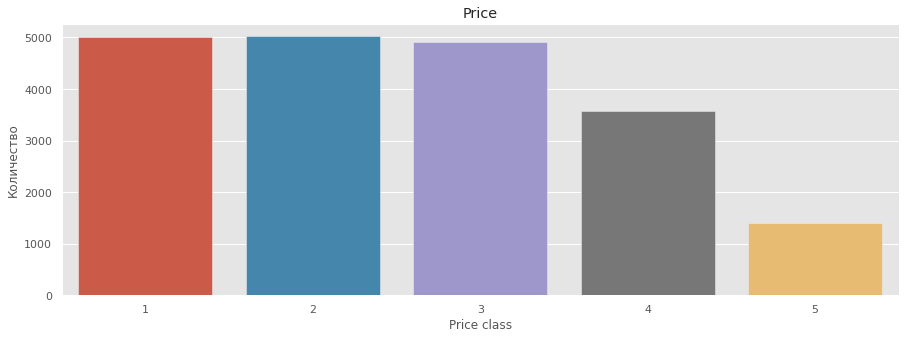

In [38]:
# Распределение параметра price_class
sns.countplot(x='price_class', data=df)
plt.xlabel('Price class')
plt.ylabel('Количество')
plt.title('Price')

####                                    Анализ параметра host id

In [39]:
# проверка на уникальность
df['host_id'].nunique() / len(df)

0.490424729831616

In [40]:
df['host_id'].nunique()

9757

In [41]:
# сравнение частоты встречаемости id каждого хозяина с параметром calculated_host_listings_count

df_copy = df.copy(deep=True)  #создание копии данных

tags, C = np.unique(df_copy.host_id, return_counts=1, return_inverse=1)[1:]
df_copy['host_id_сount'] = C[
    tags]  #создание столбца с числом встречаемости каждого уникального значения host_id

df_copy['filtered_host'] = df_copy['host_id_сount'] == df_copy[
    'calculated_host_listings_count']  #булевое значение при сравнении столбцов
df_copy['filtered_host'].value_counts()

True     19892
False        3
Name: filtered_host, dtype: int64

#### Анализ параметра host_name

In [42]:
# объем уникальных значений в столбце host_name
df['host_name'].nunique() / len(df)

0.2100025131942699

In [43]:
# словарь уникальных значений с учетом группировки по host_id
dict_name_host = df.groupby(df.host_name)['host_id'].nunique()

In [44]:
# список наиболее популярных имен с учетом уникальности по параметру host_id
[
    keys for keys, values in dict_name_host.items()
    if values == dict_name_host.max()
]

['Maria']

In [45]:
# Частота встречаемости самого популярного имени
dict_name_host.max() / df['host_id'].nunique()

0.01065901404120119

#### Анализ параметра calculated_host_listings_count

Text(0.5, 1.0, 'Количество собственности у арендодателей')

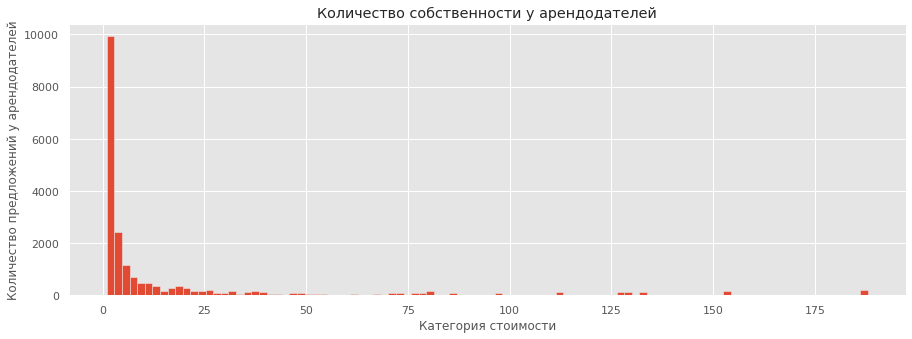

In [46]:
# гистограмма распределения количества предложений для аренды у арендодателей
df["calculated_host_listings_count"].hist(bins=100)
plt.xlabel('Категория стоимости')
plt.ylabel('Количество предложений у арендодателей')
plt.title('Количество собственности у арендодателей')

In [47]:
# необходимо добавить группировку по id_host
df["calculated_host_listings_count"].value_counts(normalize=True).max()

0.35320432269414426

#### Анализ параметра room_type

In [48]:
df['room_type'].value_counts(normalize=True)

Private room       0.496507
Entire home/apt    0.474391
Hotel room         0.018296
Shared room        0.010807
Name: room_type, dtype: float64

Text(0.5, 1.0, 'Количество предложений по типам размещения')

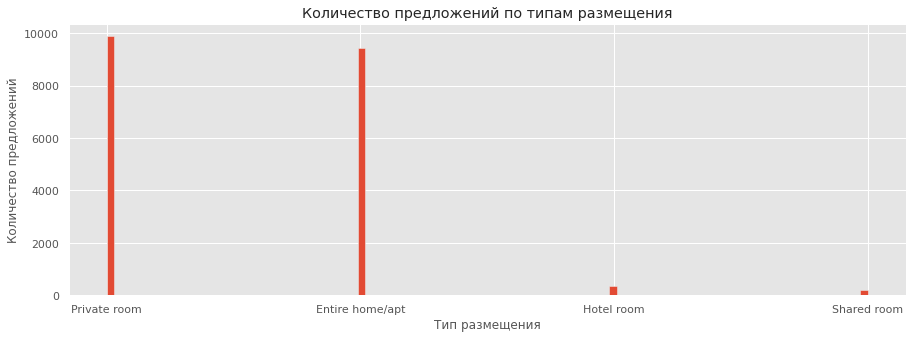

In [49]:
# Количество предложений по типам размещения
df['room_type'].hist(bins=100)
plt.xlabel('Тип размещения')
plt.ylabel('Количество предложений')
plt.title('Количество предложений по типам размещения')

Text(0.5, 1.0, 'Распределение стоимости по типу размещения')

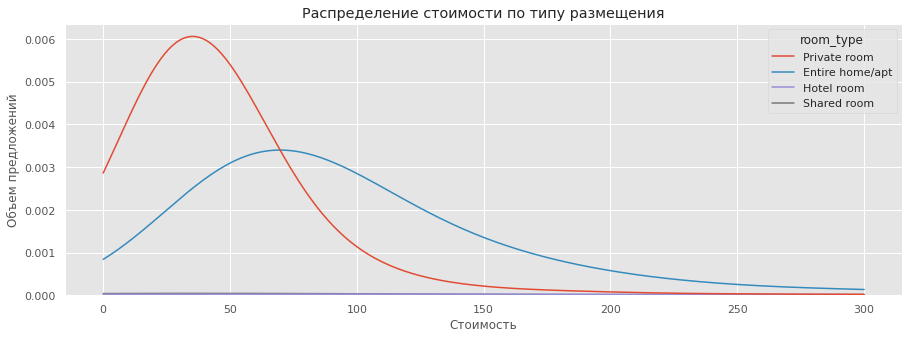

In [50]:
# распределение стоимости по типу размещения
sns.kdeplot(data=df, x="price", hue="room_type",clip=(0, 300))
plt.xlabel('Стоимость')
plt.ylabel('Объем предложений')
plt.title('Распределение стоимости по типу размещения')

####                                        Анализ параметра number_of_reviews

In [51]:
df['number_of_reviews'].describe()

count    19895.000000
mean        32.144861
std         63.004152
min          0.000000
25%          0.000000
50%          4.000000
75%         34.000000
max        761.000000
Name: number_of_reviews, dtype: float64

Text(0.5, 1.0, 'Количество')

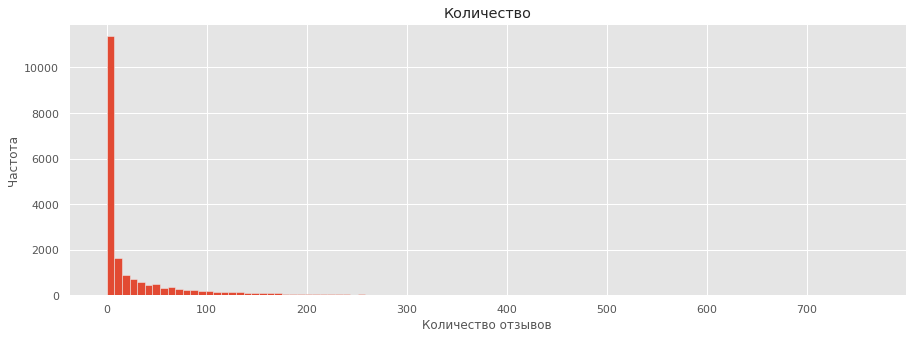

In [52]:
# Распределение параметра number_of_reviews
df['number_of_reviews'].hist(bins=100)
plt.xlabel('Количество отзывов')
plt.ylabel('Частота')
plt.title('Количество')

In [53]:
# среднее количество отзывов
df['number_of_reviews'].mean()

32.14486051771802

In [54]:
df['number_of_reviews'].max()

761

In [55]:
# Группировка по количеству отзывов
number_of_reviews_class = {0: 'no_reviews'}

rank = df['number_of_reviews'].mean()
max_count_review = df['number_of_reviews'].max() + 1

for number_of_reviews in range(1, max_count_review):

    if (number_of_reviews < rank):
        number_of_reviews_category = 'few reviews'

    elif (number_of_reviews >= rank):
        number_of_reviews_category = 'many reviews'

    number_of_reviews_class[number_of_reviews] = number_of_reviews_category

# number_of_reviews_class

In [56]:
# Добавление столбца с номинативными данными категорий отзывов (без отзывов, более и менее среднего значения)
df['number_of_reviews_class'] = df['number_of_reviews'].map(
    number_of_reviews_class)

#### Анализ параметра reviews_per_month

####                                  Анализ параметра minimum_nights

Text(0.5, 1.0, 'Количество предложений для аренды по районам')

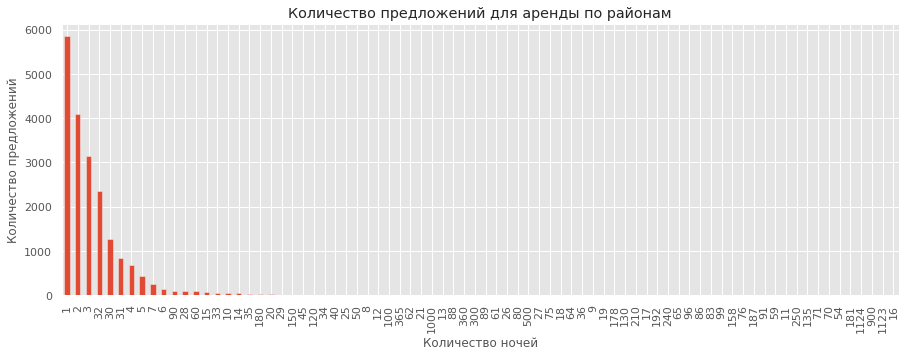

In [57]:
# Распределение minimum_nights
df['minimum_nights'].value_counts().plot.bar()
plt.xlabel('Количество ночей')
plt.ylabel('Количество предложений')
plt.title('Количество предложений для аренды по районам')

/home/kate/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='minimum_nights'>

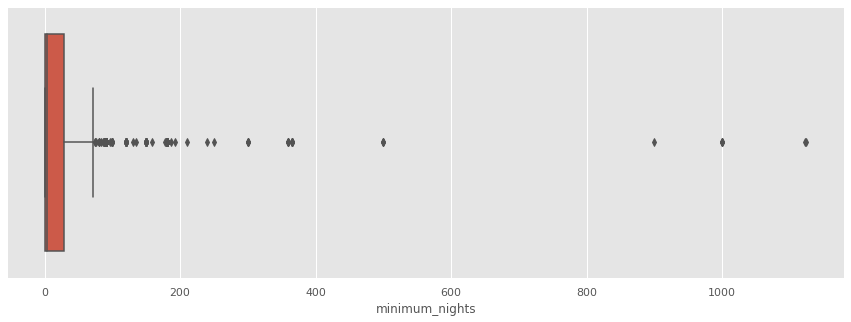

In [58]:
sns.boxplot(df['minimum_nights'], orient='h')

In [59]:
# Группировка по длительности аренды
minimum_nights_class = {}

minimum_nights_category = 1

max_count_nights = df['minimum_nights'].max()

for minimum_nights in range(1, max_count_nights):

    if (minimum_nights < 30):
        minimum_nights_category = 'short_term_rent'

    elif (minimum_nights >= 30):
        minimum_nights_category = 'long_term_rent'

    minimum_nights_class[minimum_nights] = minimum_nights_category

# minimum_nights_class

In [60]:
# Добавление столбца с номинативными данными категории длительности аренды  2 категории срока аренды
# (краткосрочная <30 дней, долгосрочная >30 дней)
df['minimum_nights_class'] = df['minimum_nights'].map(minimum_nights_class)

Text(0.5, 1.0, 'Распределение стоимости по длительности аренды')

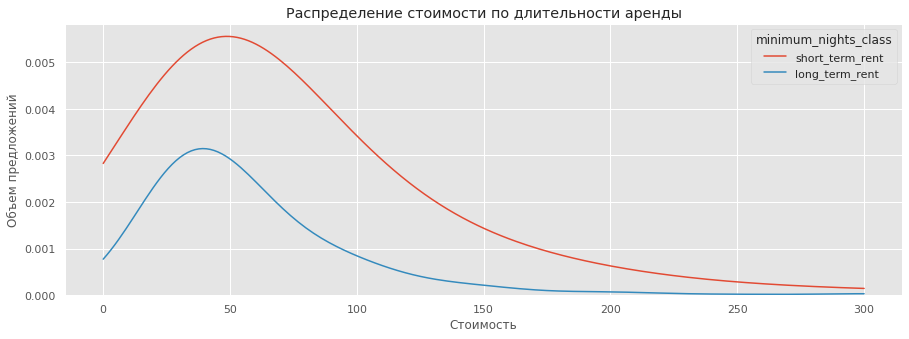

In [61]:
# Распределение стоимости по длительности аренды
sns.kdeplot(data=df, x="price", hue="minimum_nights_class",clip=(0, 300))
plt.xlabel('Стоимость')
plt.ylabel('Объем предложений')
plt.title('Распределение стоимости по длительности аренды')

#### Анализ параметров latitude и longitude

####                                Анализ параметра neighbourhood_group

In [62]:
df['neighbourhood_group'].value_counts()

Eixample               6700
Ciutat Vella           4749
Sants-Montjuïc         2260
Sant Martí             2028
Gràcia                 1670
Sarrià-Sant Gervasi     840
Horta-Guinardó          630
Les Corts               420
Sant Andreu             329
Nou Barris              269
Name: neighbourhood_group, dtype: int64

Text(0.5, 1.0, 'Количество предложений для аренды по районам')

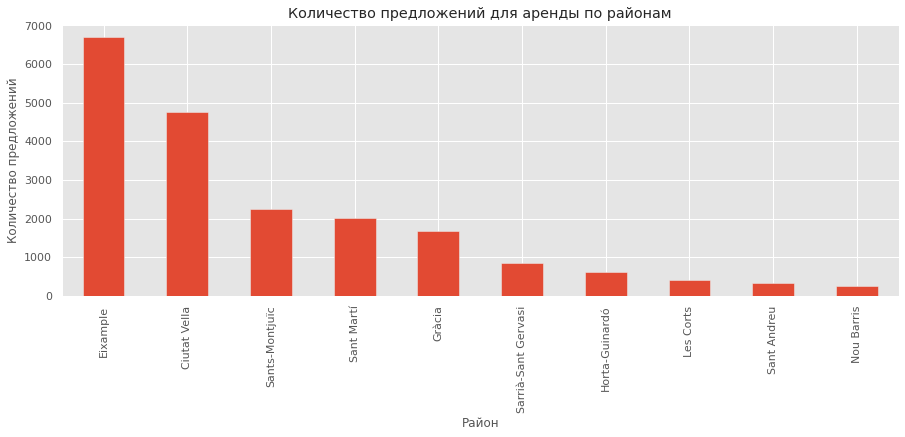

In [63]:
# Количество предложений для аренды по районам
df['neighbourhood_group'].value_counts().plot.bar()
plt.xlabel('Район')
plt.ylabel('Количество предложений')
plt.title('Количество предложений для аренды по районам')

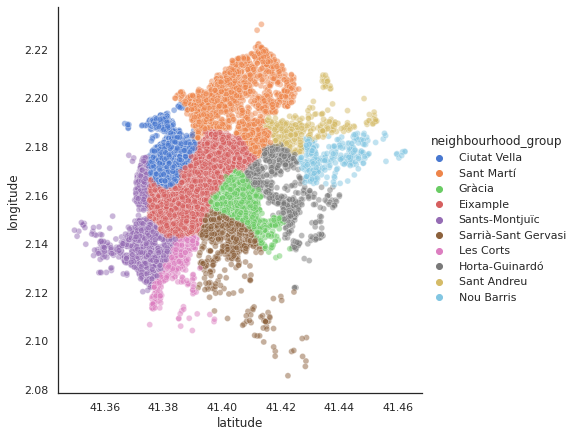

In [64]:
sns.set_theme(style="white")

sns.relplot(x="latitude", y="longitude", hue="neighbourhood_group",
            sizes=(40, 400), alpha=.5, palette="muted",
            height=6, data=df)

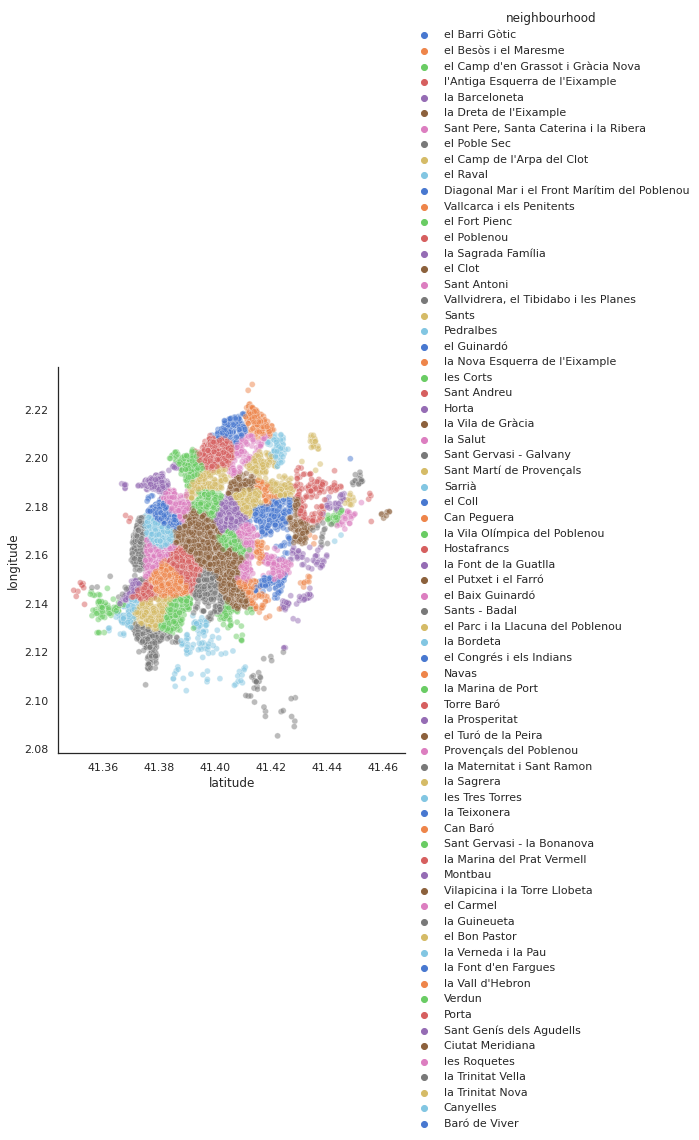

In [65]:
sns.set_theme(style="white")

sns.relplot(x="latitude", y="longitude", hue="neighbourhood",
            sizes=(60, 50), alpha=.5, palette="muted",
            height=6, data=df);

Text(0.5, 1.0, 'Распределение стоимости по районам')

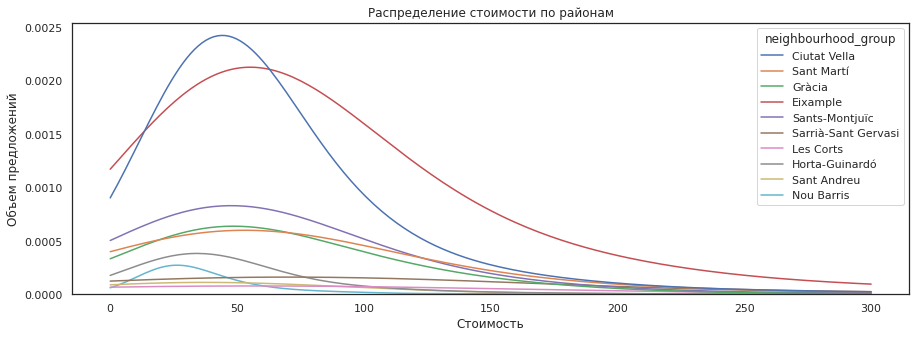

In [66]:
# распределение стоимости по районам
sns.kdeplot(data=df, x="price", hue="neighbourhood_group",clip=(0, 300));

plt.xlabel('Стоимость')
plt.ylabel('Объем предложений')
plt.title('Распределение стоимости по районам')

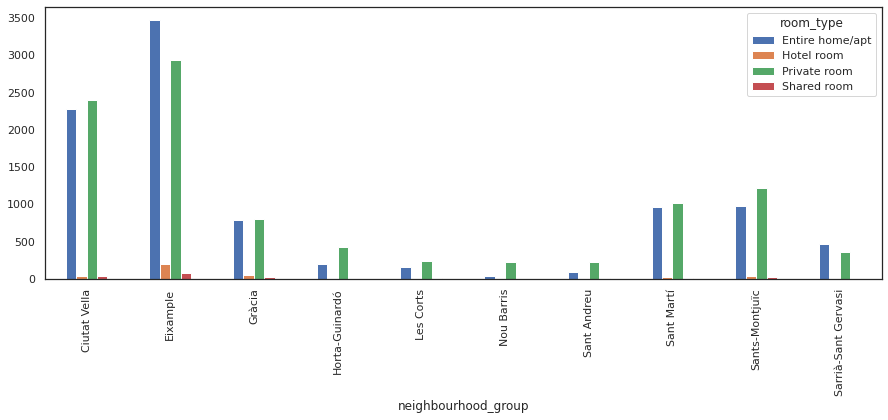

In [67]:
# Распределение типов предложений для аренды по районам

pd.pivot_table(df,
               index="neighbourhood_group",
               columns="room_type",
               values='id',
               aggfunc='count').plot(kind='bar');

#### Анализ параметра neighbourhood 

In [68]:
df['neighbourhood'].value_counts()

la Dreta de l'Eixample                   2151
el Raval                                 1586
el Barri Gòtic                           1405
Sant Pere, Santa Caterina i la Ribera    1276
la Sagrada Família                       1096
                                         ... 
Ciutat Meridiana                            7
Torre Baró                                  4
Can Peguera                                 3
Canyelles                                   2
Baró de Viver                               1
Name: neighbourhood, Length: 71, dtype: int64

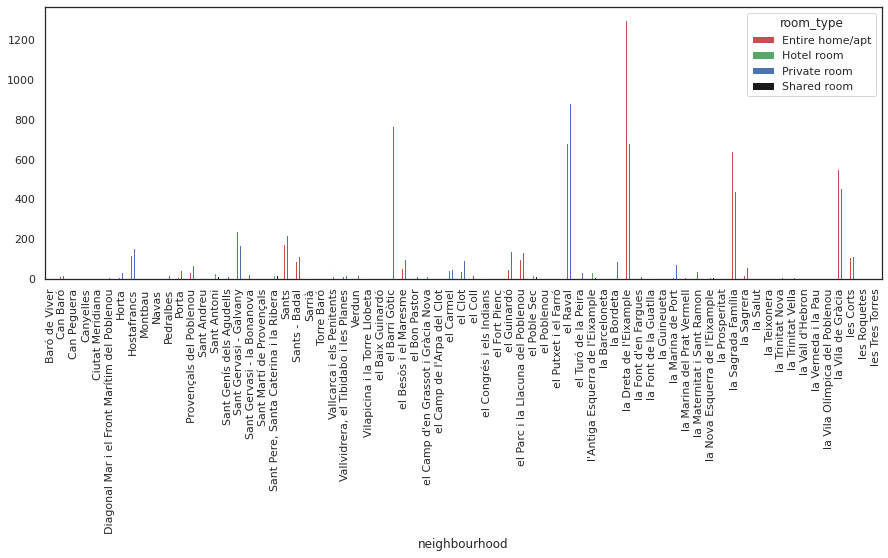

In [69]:
# средняя цена по кварталам
pd.pivot_table(df,
               index="neighbourhood",
               columns="room_type",
               values='price',
               aggfunc='count').plot(kind='bar',color=['r', 'g', 'b','k']);

In [70]:
pivot_table_categories = df.pivot_table(values=['price'],
                                        index=[
                                            'neighbourhood'
                                        ])
pivot_table_categories

,price
neighbourhood,
Baró de Viver,22.000000
Can Baró,50.628571
Can Peguera,37.666667
Canyelles,32.500000
Ciutat Meridiana,42.571429
...,...
la Vila Olímpica del Poblenou,149.068421
la Vila de Gràcia,83.114692
les Corts,115.363248


####                                     Анализ параметра availability_365

Text(0.5, 1.0, 'Количество доступных дней для бронирования')

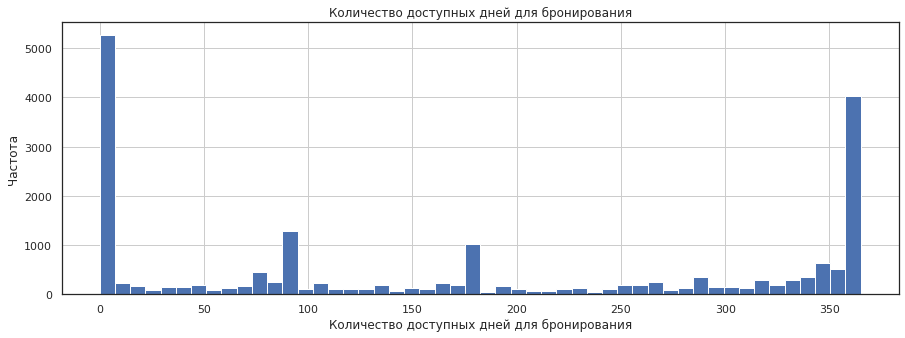

In [71]:
# распределение параметра availability_365
df['availability_365'].hist(bins=50)
plt.xlabel('Количество доступных дней для бронирования')
plt.ylabel('Частота')
plt.title('Количество доступных дней для бронирования')

Text(0.5, 1.0, 'Наиболее востребованные районы')

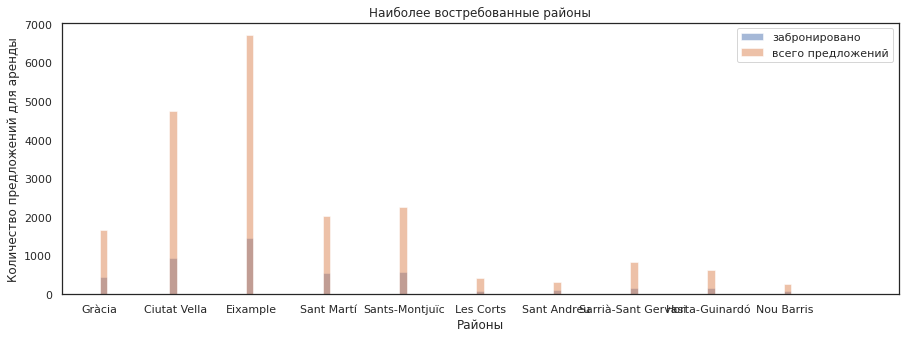

In [72]:
# Наиболее востребованные районы по availability_365
#выбор 2х столбцов по заданному фильтру
filtered_availability = df[['availability_365', 'neighbourhood_group']]

# жилье недоступное для бронирования
filtered_availability = filtered_availability[
    filtered_availability['availability_365'] == 0]

# Наиболее востребованные районы
X = filtered_availability['neighbourhood_group']
Y = df['neighbourhood_group']

bins = np.linspace(0, 10, 100)

plt.hist(X, bins, alpha=0.5, label='забронировано')
plt.hist(Y, bins, alpha=0.5, label='всего предложений')
plt.legend(loc='upper right')
plt.xlabel('Районы')
plt.ylabel('Количество предложений для аренды')
plt.title('Наиболее востребованные районы')

# разбить забронированное жилье по стоимости

#### Анализ параметра last_review 

In [73]:
# корректировка формата даты
df['last_review_dt'] = pd.to_datetime(df['last_review'], format='%Y-%m-%d')

In [74]:
# Влияние даты последнего отзыва на стоимость

<AxesSubplot:xlabel='last_review_dt', ylabel='Density'>

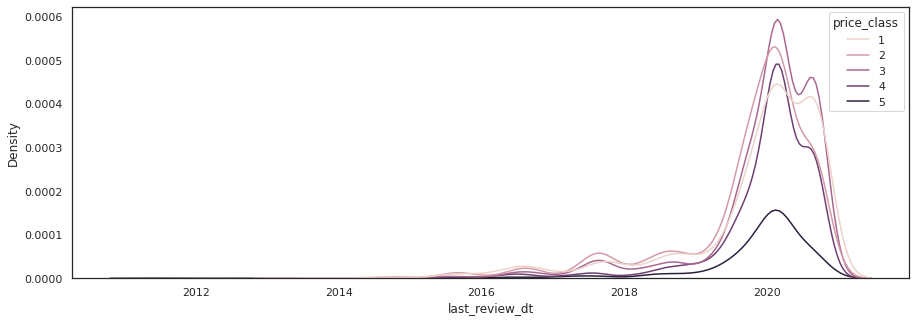

In [75]:
# сравнить недвижимость с отзывами за последние 6 месяцев и без в каждой ценовой категории 
sns.kdeplot(data=df, x="last_review_dt", hue="price_class")

#### Numeric columns

In [76]:
df_numeric = df.select_dtypes(include=[np.number])
numeric_cols = df_numeric.columns.values
print(numeric_cols)

['id' 'host_id' 'latitude' 'longitude' 'price' 'minimum_nights'
 'number_of_reviews' 'reviews_per_month' 'calculated_host_listings_count'
 'availability_365' 'price_class']


### Нерелевантные признаки

In [77]:
# удаление неинформативных признаков host_id и host_name
df = df.drop(['host_id', 'host_name'], axis=1)

### Сводная таблица факторов к стоимости

In [78]:
# df[["neighbourhood_group", "neighbourhood",
#     "room_type"]] = df[["neighbourhood_group", "neighbourhood",
#                         "room_type"]].astype("category")

In [79]:
df.dtypes

id                                         int64
name                                      object
neighbourhood_group                       object
neighbourhood                             object
latitude                                 float64
longitude                                float64
room_type                                 object
price                                      int64
minimum_nights                             int64
number_of_reviews                          int64
last_review                               object
reviews_per_month                        float64
calculated_host_listings_count             int64
availability_365                           int64
price_class                                int64
number_of_reviews_class                   object
minimum_nights_class                      object
last_review_dt                    datetime64[ns]
dtype: object

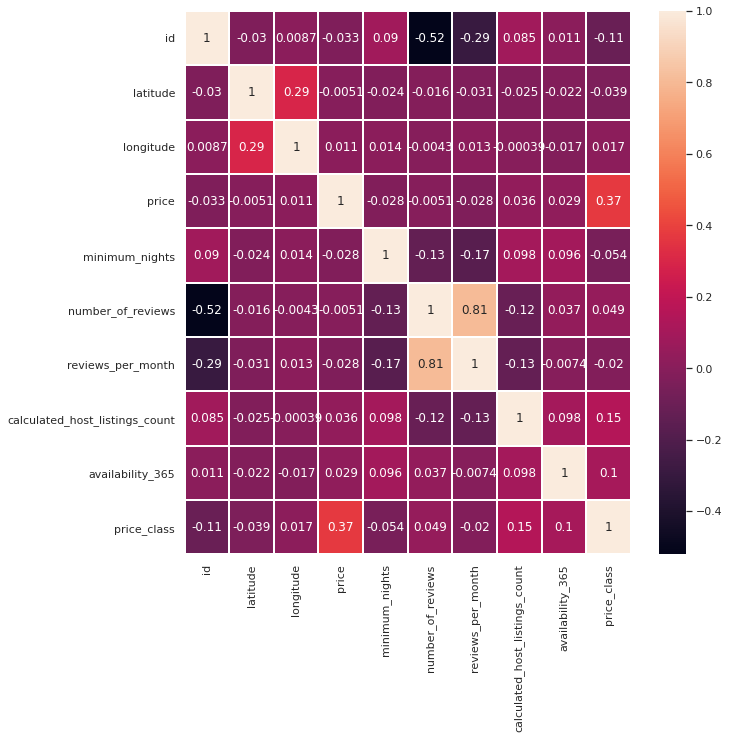

In [80]:
# оценка корелляции признаков после введения категорий
f, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(df.corr(), annot=True, linewidths=1)
plt.show()

In [81]:
pivot_table_categories = df.pivot_table(values=['price'],
                                        index=[
                                            'neighbourhood_group', 'room_type',
                                            'minimum_nights_class',
                                            'price_class',
                                            'number_of_reviews_class'
                                        ])
pivot_table_categories

price
neighbourhood_group room_type       minimum_nights_class price_class number_of_reviews_class             
Ciutat Vella        Entire home/apt long_term_rent       1           few reviews                28.569343
                                                                     many reviews               28.250000
                                                                     no_reviews                 28.657658
                                                         2           few reviews                43.721154
                                                                     many reviews               45.000000
...                                                                                                   ...
Sarrià-Sant Gervasi Private room    short_term_rent      5           no_reviews               1551.142857
                    Shared room     short_term_rent      1           few reviews                19.000000
                                                         2           no_reviews                 35.000000
                                                         4           no_reviews                100.000000
                                                         5           no_reviews                760.000000

[626 rows x 1 columns]

### Порядковая регрессия

In [82]:
from bevel.linear_ordinal_regression import OrderedLogit

In [83]:
# Назначение зависимых(Y) и независимых(X) переменных

Y = df.price_class
X = df[[
    'minimum_nights', 'number_of_reviews', 'reviews_per_month',
    'availability_365', 'latitude', 'longitude',
    'calculated_host_listings_count'
]]

In [84]:
X.dtypes

minimum_nights                      int64
number_of_reviews                   int64
reviews_per_month                 float64
availability_365                    int64
latitude                          float64
longitude                         float64
calculated_host_listings_count      int64
dtype: object

In [85]:
# Построение регрессионной модели
model = OrderedLogit()
model.fit(X, Y)

In [86]:
model.print_summary()

n=19895
                                  beta  se(beta)      p  lower 0.95  upper 0.95     
attribute names                                                                     
minimum_nights                 -0.0103    0.0008 0.0000     -0.0118     -0.0087  ***
number_of_reviews               0.0057    0.0004 0.0000      0.0050      0.0064  ***
reviews_per_month              -0.3001    0.0201 0.0000     -0.3394     -0.2607  ***
availability_365                0.0012    0.0001 0.0000      0.0010      0.0013  ***
latitude                       -7.0769    0.9048 0.0000     -8.8503     -5.3035  ***
longitude                       4.2975    0.7518 0.0000      2.8241      5.7709  ***
calculated_host_listings_count  0.0087    0.0004 0.0000      0.0079      0.0095  ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1 

Somers' D = 0.208


In [87]:
# df.sample(5)

In [88]:
# import pandas_profiling
# df.profile_report()

In [89]:
# # Кодировка категориальных данных
# df.minimum_nights_class = np.where(
#     df.minimum_nights_class == 'short_term_rent', 1, 0)

In [90]:
# Y = df.availability_365  #ЗП
# X = df.loc[:, [
#     'latitude', 'longitude', 'price', 'minimum_nights', 'number_of_reviews',
#     'calculated_host_listings_count', 'price_class'
# ]]  #НП
# X = sm.add_constant(X)  #Intercept

In [91]:
# zeroinf = sm.ZeroInflatedPoisson(Y, X).fit(maxiter=100, method="ncg")
# zeroinf.summary()